In [793]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [794]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
df.head()
my_stocks = df['Symbol'].values.tolist()
n = len(my_stocks)
# my_stocks.remove('BRK.B')
# my_stocks.remove('BF.B')
my_stocks.remove('CARR')
my_stocks.remove('LUMN')
my_stocks.remove('OTIS')
my_stocks.remove('VNT')
my_stocks.remove('CTVA')
my_stocks.remove('FOXA')
my_stocks.remove('DOW')
my_stocks.remove('FOX')
my_stocks.remove('VIAC')


# my_stocks = ['ANSS', 'NDAQ', 'SPY', 'AMZN', 'AAPL', 'MSFT', 'FB', 'GOOG','NFLX','SPOT','SNE',
#              'TSLA', 'IBM', 'ADSK', 'MRNA', 'BNTX', 'AMGN','ABBV', 'GILD', 'BIIB', 'EW', 'DHR',
#              'WAT', 'BSX', 'DE', 'TM', 'CAT', 'MMM', 'GE', 'BA', 'EADSY', 'MAR', 'WYNN', 'CCL',
#              'DAL', 'NEE', 'JPM', 'GS', 'BAC', 'PYPL', 'V', 'FDX', 'SHW', 'ABT', 'EBAY', 'WORK',
#              'SNAP', 'PINS', 'TGT', 'TWTR', 'JNJ', 'COLM', 'HD', 'AZN', 'CRM', 'APPN', 
#               'NIO', 'REGI', 'CSIQ', 'FTNT', 'PPLT', 'THC', 'CORT', 'HNGR', 'NXGN', 'EOG', 
#              'UNH', 'CVS', 'HTH', 'OMF', 'DHT', 'BBY', 'GLD' ]

# my_stocks.remove('BNTX')
# my_stocks.remove('WORK')
# my_stocks.remove('PINS')
# my_stocks.remove('SPOT')
# my_stocks.remove('MRNA')
# my_stocks.remove('NIO')

trade_freq = 2


In [795]:
import urllib.request

print('Downloading data...')

for symbol in my_stocks:
    url2020 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1577836800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    url2019 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1546300800&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'
    url2018 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1514764800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    
    urllib.request.urlretrieve(url2018,symbol+'.csv')
    

## Now read the data using pandas

In [796]:
my_dict = {}
import os
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv(symbol+'.csv')
    os.remove(symbol+'.csv')

n = len(my_dict)
T_all = my_dict['AAPL'].shape[0]

my_dict['AAPL'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
761,2021-01-11,129.190002,130.169998,128.500000,128.979996,128.979996,100620900
762,2021-01-12,128.500000,129.690002,126.860001,128.800003,128.800003,91951100
763,2021-01-13,128.759995,131.449997,128.490005,130.889999,130.889999,88636800
764,2021-01-14,130.800003,131.000000,128.759995,128.910004,128.910004,90221800
765,2021-01-15,128.779999,130.220001,127.000000,127.139999,127.139999,111598500


In [797]:
all_stocks = np.zeros([n,T_all])
for i, symbol in enumerate(my_stocks):
    try:
        all_stocks[i,:] =  np.float32(my_dict[symbol].Open)/2 
    except:
        print("some problem for data of",symbol)
all_times =  my_dict[symbol].Date

stocks = all_stocks[:,::trade_freq]
times = all_times.iloc[::trade_freq]
T = len(stocks[0])

## Online newton step algorithm and expert

In [798]:
x = np.ones(n)/n
f = np.zeros(T)

# Parameter Free Expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

x_pfe = x


PFE portfolio on2021-01-14


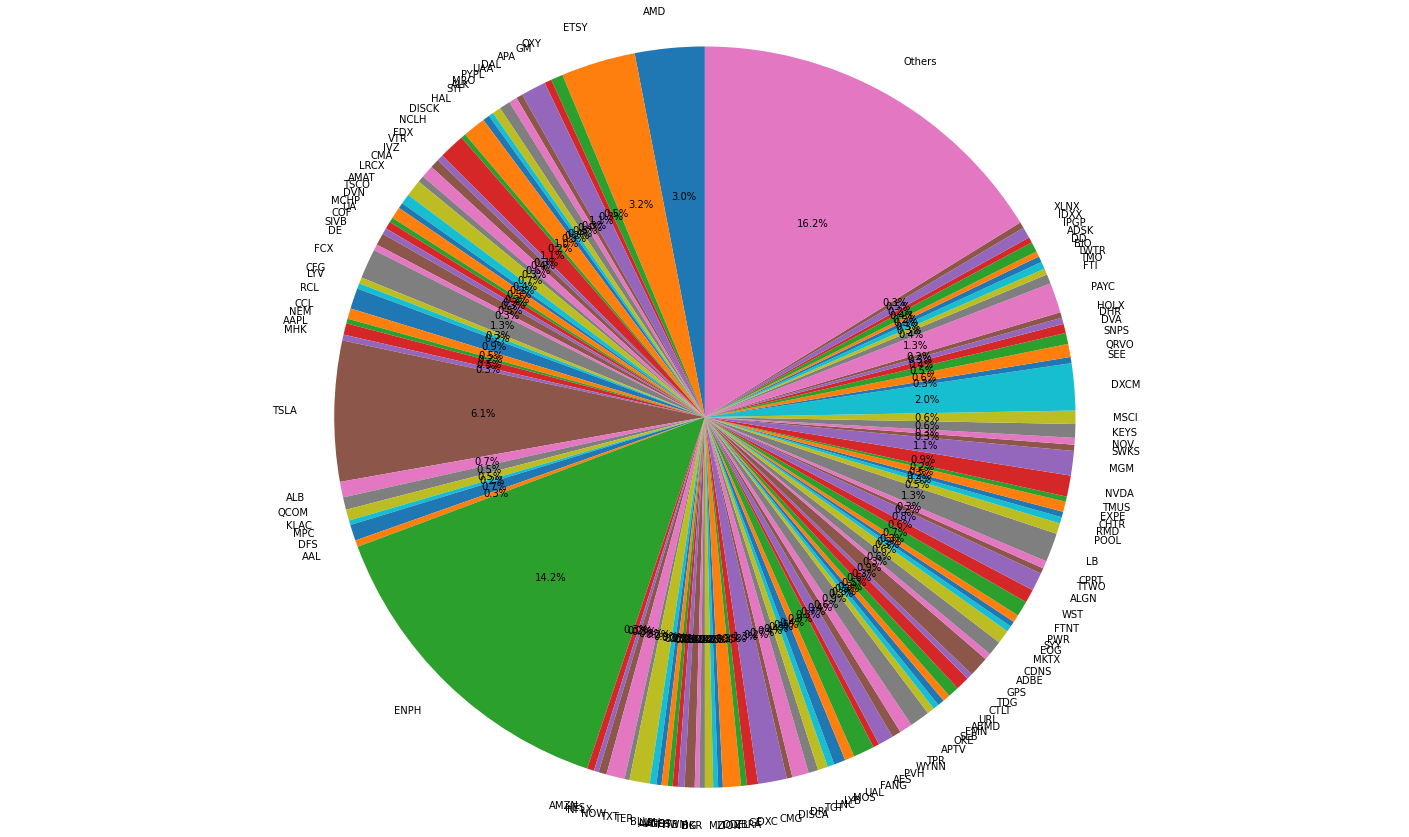

In [810]:
biggest = np.argsort(x)
print('PFE portfolio on' + times.iloc[-1])
# for i in biggest[::-1]:
#     if x_pfe[i]*100 > 0.1:
#       symbol=my_stocks[i]
#       print(symbol + '\t'+str(np.float16(x_pfe[i]*100))+ '%')

sizes = []
labels = []
for i in biggest[::-1]:
  if x_pfe[i]*100 > 0.2:
    sizes.append(x_pfe[i]*100)
    labels.append(my_stocks[i])
labels.append('Others')
sizes.append(100 - sum(sizes))

fig1, ax1 = plt.subplots()
fig1.set_size_inches(25, 15)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [800]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [801]:
# ONS
alpha = 0.5
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

x_ons = x


ONS portfolio on 2021-01-14


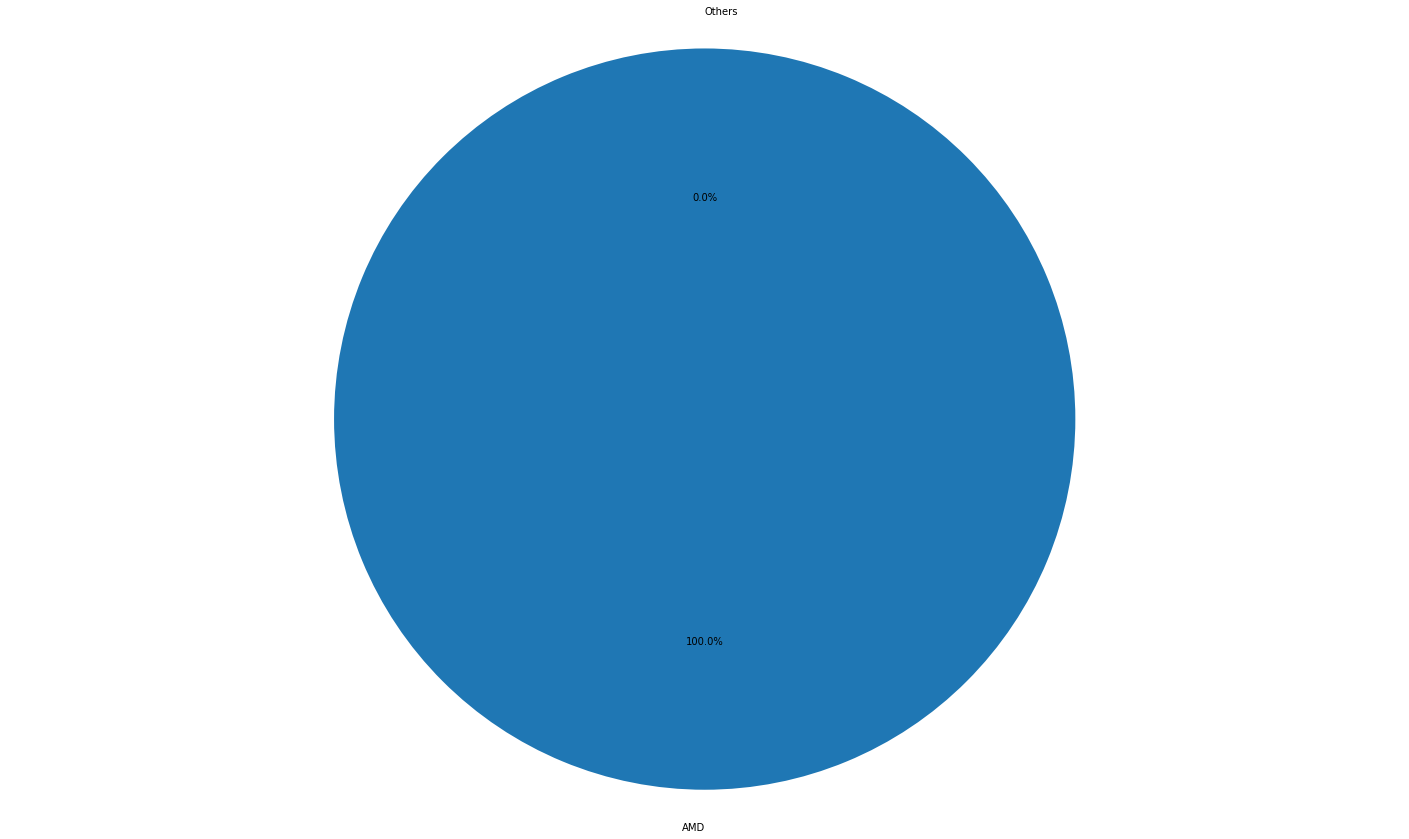

In [811]:
print('ONS portfolio on ' + times.iloc[-1])
sizes = []
labels = []
for i in biggest[::-1]:
  if x_ons[i]*100 > 0.1:
    sizes.append(x_ons[i]*100)
    labels.append(my_stocks[i])
labels.append('Others')
sizes.append(100 - sum(sizes))

fig1, ax1 = plt.subplots()
fig1.set_size_inches(25, 15)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Backtest results

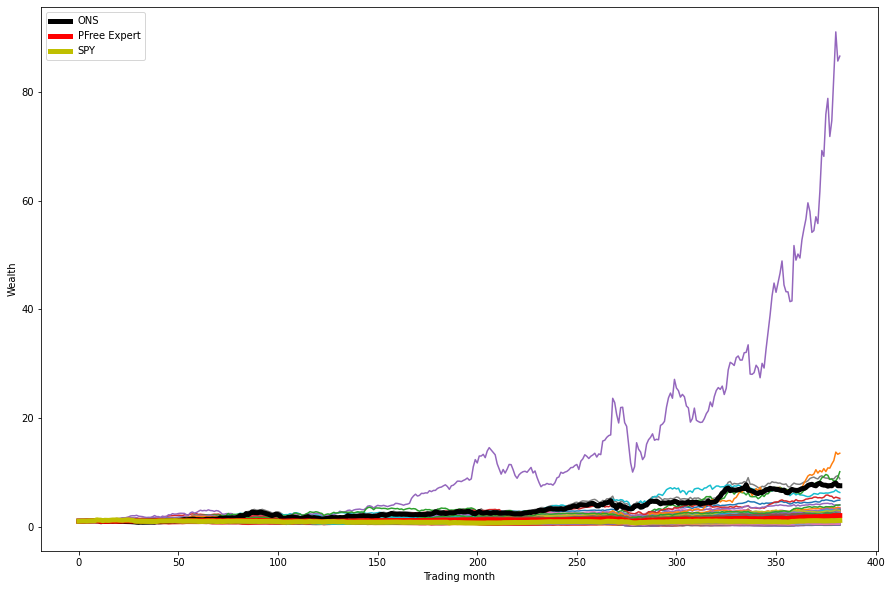

In [803]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
# ali = times.to_numpy()
# xtimes = [ali[i][2:4]+'/'+ali[i][5:-3] for i in range(len(times))]
for i, symbol in enumerate(my_stocks):
    ax.plot(range(T),np.exp(np.log(stocks[i,:]) - np.log(stocks[i,0])))

ax.plot(range(T), np.exp(log_wealth_ons ), 'k' , linewidth=5, label='ONS')
ax.plot(range(T), np.exp(log_wealth_expert ), 'r' , linewidth=5, label='PFree Expert')
ax.plot(range(T), np.exp(np.log(stocks[2,:])- np.log(stocks[2,0])), 'y' , linewidth=5, label='SPY')

ax.legend()
ax.set_xlabel('Trading month')
ax.set_ylabel('Wealth')
plt.show()


In [807]:
times.iloc[-1]

'2021-01-14'